# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)

**Zillow** is online real estate marketing company in United States. According to official page of Zillow, **Zestimate** is Zillow’s estimate of a home’s market value. The Zestimate incorporates public and user-submitted data, taking into account home facts, location and market conditions.
<br>

This notebook is being written 3 years after competition, just for purpose of studying and sharing ideas! 

## Contents
**Part 1**
1. Load and preview dataset
2. Data Cleansing
3. EDA


**Part 2**
1. Feature Engineering
2. Modeling

## 1. Load and preview datasets

Note) <br>
`train_2016` data was updated - containing data from 2016-01-01 to 2016-12-31 so there's no need to predict log error in 2016. Instead, I'm going to predict log error of 2017 by using given datasets from 2016 and 2017.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

In [2]:
train_2016 = pd.read_csv("../input/zillow-prize-1/train_2016_v2.csv", header = 0)
train_2017 = pd.read_csv("../input/zillow-prize-1/train_2017.csv", header = 0)
properties_2016 = pd.read_csv("../input/zillow-prize-1/properties_2016.csv", header = 0)
properties_2017 = pd.read_csv("../input/zillow-prize-1/properties_2017.csv", header = 0)

print(train_2016.shape)
print(train_2017.shape)
print(properties_2016.shape)
print(properties_2017.shape)

(90275, 3)
(77613, 3)
(2985217, 58)
(2985217, 58)


We have to merge given datasets to conduct analysis and modeling process.
1. Merge train_2016 and properties_2016, train_2017 and properties_2017, joining on `parcelid`
2. Concatenate data from 2016 and 2017 and make `data` dataset which is total data.

In [3]:
# make 2016 and 2017 merged data
data2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid')
data2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')

print(data2016.shape)
print(data2017.shape)

(90275, 60)
(77613, 60)


In [4]:
# final merged data
data = pd.concat([data2016, data2017], axis = 0)
data.head(3)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13


## 2. Data Cleansing

### (1) Missing values
Calculate percentage of missing values in each variable. It's quite normal to drop variable with missing percentage more than 90% of total data, but I'll take a look at those data if they have any specialties first.

In [5]:
# calcuate missing %
na_ratio = data.isna().sum().sort_values(ascending = False)/len(data)
na_ratio

buildingclasstypeid             0.999815
finishedsquarefeet13            0.999553
basementsqft                    0.999446
storytypeid                     0.999446
yardbuildingsqft26              0.999017
fireplaceflag                   0.997653
architecturalstyletypeid        0.997212
typeconstructiontypeid          0.996891
finishedsquarefeet6             0.995193
decktypeid                      0.992424
pooltypeid10                    0.990315
poolsizesum                     0.989052
pooltypeid2                     0.986431
hashottuborspa                  0.976746
taxdelinquencyyear              0.972106
taxdelinquencyflag              0.972106
yardbuildingsqft17              0.969986
finishedsquarefeet15            0.960742
finishedsquarefeet50            0.923205
finishedfloor1squarefeet        0.923205
fireplacecnt                    0.893405
threequarterbathnbr             0.868275
pooltypeid7                     0.810731
poolcnt                         0.797037
numberofstories 

`to_drop` is set of variables which have more than 90% missing values. There are 3 object type variables(categorical), 17 float type variables in `to_drop` variables. 
* float: Those are more reasonable to drop, since it's hard to estimate missing values from existing values in this case
* object: Object variables are categorical variables. NaN values in those variables might have some meanings, so we have to consider those first.

In [6]:
to_drop = na_ratio[na_ratio>0.9].index.tolist()
data[to_drop].dtypes

buildingclasstypeid         float64
finishedsquarefeet13        float64
basementsqft                float64
storytypeid                 float64
yardbuildingsqft26          float64
fireplaceflag                object
architecturalstyletypeid    float64
typeconstructiontypeid      float64
finishedsquarefeet6         float64
decktypeid                  float64
pooltypeid10                float64
poolsizesum                 float64
pooltypeid2                 float64
hashottuborspa               object
taxdelinquencyyear          float64
taxdelinquencyflag           object
yardbuildingsqft17          float64
finishedsquarefeet15        float64
finishedsquarefeet50        float64
finishedfloor1squarefeet    float64
dtype: object

Those are categorical variables with missing percentage over 90%: `fireplaceflag`, `hashottuborspa`, `taxdelinquencyflag` <br>
NA values in each variable means that **there is no fireplace/hot tub(spa) and property taxes for this parcel are not past due as of 2015.** That is, NA is unique category in those variables, so it better not drop `fireplaceflag`, `hashottuborspa`, `taxdelinquencyflag` variables.<br>
<br>
Therefore, I'll drop only 17 float variables among `to_drop` variables.



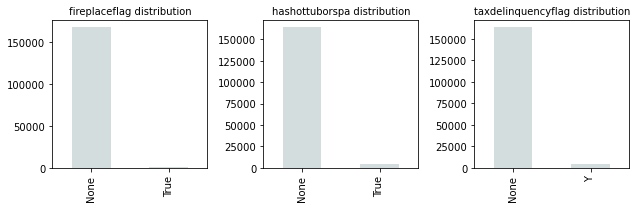

In [7]:
na_obj = data[to_drop].select_dtypes('object').columns # object variables in to_drop list
data[na_obj] = data[na_obj].fillna('None') # value_counts() method does not count NA, so replace it with 'None'

fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9,3))
for i, col in enumerate(na_obj):
    data[col].value_counts().plot.bar(ax = ax[i], color = '#d4dddd')
    ax[i].set_title(f'{col} distribution', fontsize = 10);
plt.tight_layout()
plt.show()

In [8]:
# drop 17 float variables in to_drop
na_float = data[to_drop].select_dtypes('float').columns 
data.drop(na_float, axis = 1, inplace = True)

In [9]:
# dim of data after dropping NA columns
data.shape

(167888, 43)

#### Take closer look on more NA variables!

In [10]:
na_ratio = data.isna().sum().sort_values(ascending = False)/len(data)
na_cols = na_ratio[na_ratio>0].index

# ends with 'cnt'
na_cnt = na_cols[na_cols.str.endswith('cnt')]
na_others = na_cols[~na_cols.str.endswith('cnt')]
print(na_cnt)
print('\n')
print(na_others)

Index(['fireplacecnt', 'poolcnt', 'garagecarcnt', 'unitcnt', 'fullbathcnt',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'taxvaluedollarcnt', 'bedroomcnt', 'roomcnt', 'bathroomcnt'],
      dtype='object')


Index(['threequarterbathnbr', 'pooltypeid7', 'numberofstories',
       'airconditioningtypeid', 'garagetotalsqft', 'regionidneighborhood',
       'heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc',
       'lotsizesquarefeet', 'finishedsquarefeet12', 'regionidcity',
       'calculatedbathnbr', 'yearbuilt', 'calculatedfinishedsquarefeet',
       'censustractandblock', 'regionidzip', 'taxamount',
       'propertycountylandusecode', 'fips', 'assessmentyear', 'regionidcounty',
       'rawcensustractandblock', 'latitude', 'longitude',
       'propertylandusetypeid'],
      dtype='object')


In [11]:
# na_cnt
data[na_cnt] = data[na_cnt].fillna(data[na_cnt].mean())
data[na_others] = data[na_others].fillna(data[na_others].mean())

In [12]:
na_ratio = data.isna().sum().sort_values(ascending = False)/len(data)
na_ratio[na_ratio>0]

propertyzoningdesc           0.352014
propertycountylandusecode    0.000208
dtype: float64

### (2) Delete variables with only 1 unique value
In our data, there are variables which has only one unique value. I removed those variables since those variables does not affect target variable, logerror.<br>
Those variables are `poolcnt` and `pooltypeid7`.

In [13]:
one_col = data.columns[data.nunique()==1]

In [14]:
# drop one_col variables
data.drop(one_col, axis = 1, inplace = True)

### (3) Datetime format
Change dtype of `transactiondate` variable to datetime, and then make variables that denote year, month, day, weekday each.

In [15]:
data['transactiondate'] = pd.to_datetime(data['transactiondate'], format = '%Y-%m-%d')

data['year'] = data['transactiondate'].dt.year
data['month'] = data['transactiondate'].dt.month
data['day'] = data['transactiondate'].dt.day
data['weekday'] = data['transactiondate'].dt.weekday

data.head(3)

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,year,month,day,weekday
0,11016594,0.0276,2016-01-01,1.000000,2.0,3.0,4.000000,2.0,1684.0,1684.0,...,360170.0,2015.0,237416.0,6735.88,None,6.037107e+13,2016,1,1,4
1,14366692,-0.1684,2016-01-01,1.814345,3.5,4.0,6.015461,3.5,2263.0,2263.0,...,585529.0,2015.0,239071.0,10153.02,None,6.049390e+13,2016,1,1,4
2,12098116,-0.0040,2016-01-01,1.000000,3.0,2.0,4.000000,3.0,2217.0,2217.0,...,119906.0,2015.0,57912.0,11484.48,None,6.037464e+13,2016,1,1,4


## 3. EDA
Simple exploration of target and features is included in this part! Also, I tried to try visualize plots neatly as much as I can, thanks to visualizaion kernel
<https://www.kaggle.com/subinium/awesome-visualization-with-titanic-dataset>

### (1) Target variable: Logerror
Target variable, `Logerror` ranges from -5 to 5, but mostly distributed around 0. Plus, distribution plots of year 2016 and 2017 are almost same!

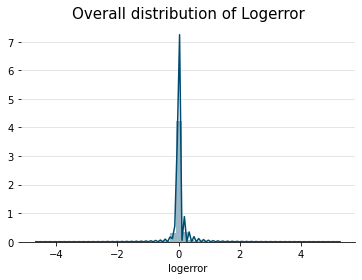

In [16]:
ax = plt.subplot(1,1,1)
sns.distplot(data['logerror'], color = '#004c70')
plt.title('Overall distribution of Logerror', fontsize = 15)

for s in ['top','left','right']:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.show()

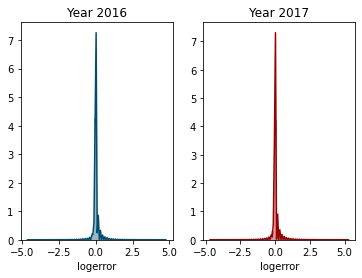

In [17]:
plt.subplot(1,2,1)
sns.distplot(data2016['logerror'], color = '#004c70')
plt.title('Year 2016')
plt.subplot(1,2,2)
sns.distplot(data2017['logerror'], color = '#990000')
plt.title('Year 2017')
plt.show()

### (2) Time values analysis
1. Transaction Date
 - Compare monthly, daily, weekly overall mean of logerror(transaction date)
2. Year Built


#### 1) Transaction Date

**Monthly Analysis**

 + The first graph shows monthly transaction amount and second one shows monthly mean of logerror. It's interesting to find that monthly transaction amount and monthly mean of logerror shows opposite trend. **To be more specific, when there is large transaction amount in certain month, logerror mean tends to be lower than other months.** I colored large transaction & lower logerror mean to red, small transaction & higher logerror mean to blue! However, it's hard to conclude that there is correlation between those two yet.
 + More generally, more transactions occur during spring and summer seasons but transaction amount is comparatively lower in winter seasons(11,12,1,2)

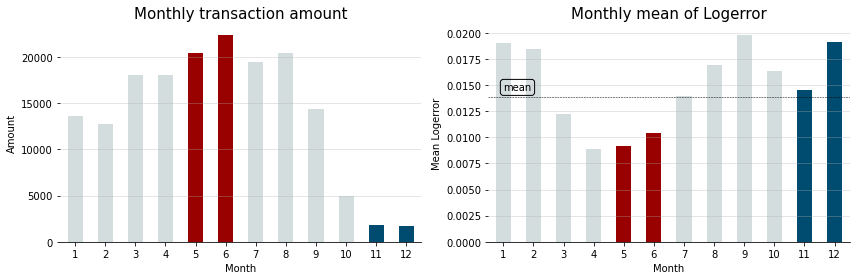

In [18]:
color_map = ['#d4dddd' for _ in range(12)]
color_map[10] = color_map[11] = '#004c70'; color_map[4] = color_map[5] = '#990000'


plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
data.groupby('month')['logerror'].count().plot.bar(color = color_map)
plt.xticks(rotation = 0); plt.xlabel('Month'); plt.ylabel('Amount')
plt.title('Monthly transaction amount', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)


ax2 = plt.subplot(1,2,2)
data.groupby('month')['logerror'].mean().plot.bar(color = color_map)
plt.axhline(data['logerror'].mean(), linestyle = '--', color = 'black', linewidth = 0.5)
plt.text(0, 0.0145, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.xticks(rotation = 0); plt.xlabel('Month'); plt.ylabel('Mean Logerror')
plt.title('Monthly mean of Logerror', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

**Weekly Analysis**
+ Weekly mean logerror comparision plot also shows interesting results. On weekdends(Saturday & Sunday), less transactions occur. It seems that most transactions are done during weekdays.
+ Weekly mean of logerror on weekends is much lower than other weekdays.

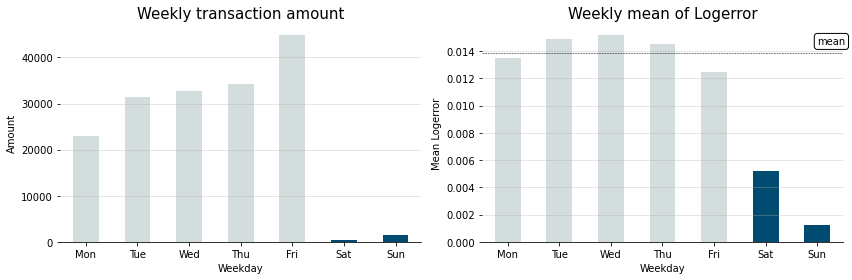

In [19]:
color_map = ['#d4dddd' for _ in range(7)]
color_map[5] = color_map[6] = '#004c70'

plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
data.groupby('weekday')['logerror'].count().plot.bar(color = color_map)
plt.xticks(range(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation = 0); plt.xticks(rotation = 0); plt.xlabel('Weekday'); plt.ylabel('Amount')
plt.title('Weekly transaction amount', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)



ax = plt.subplot(1,2,2)
data.groupby('weekday')['logerror'].mean().plot.bar(color = color_map)
plt.axhline(data['logerror'].mean(), linestyle = '--', color = 'black', linewidth = 0.5)
plt.text(6, 0.0145, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.xticks(range(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation = 0); plt.xlabel('Weekday'); plt.ylabel('Mean Logerror')
plt.title('Weekly mean of Logerror', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

#### 2) Year Built
`yearbuilt` variable denotes 'the year the principal residence was built'. 
* Most of residences were built in 100 years, especially from 1950.
* Mean logerror is large for residences that were built a long time ago(1824 ~ 1900). Recently built residences have smaller logerrors compared to old ones.

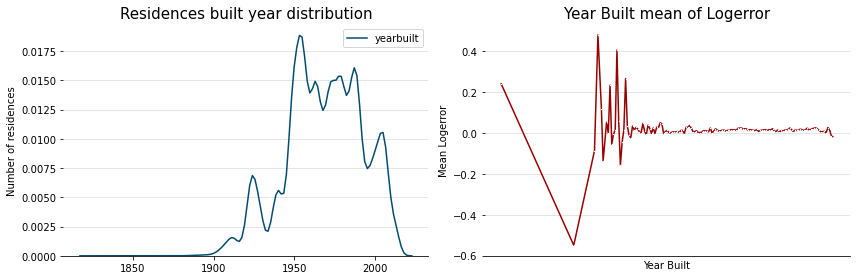

In [103]:
plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
sns.kdeplot(data['yearbuilt'], color = '#004c70');plt.legend(loc='best'); plt.ylabel('Number of residences')
plt.title('Residences built year distribution', fontsize = 15)

# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

ax2 = plt.subplot(1,2,2)
yearbuilt = data.groupby(['yearbuilt'])['logerror'].mean().reset_index()
sns.lineplot(data = yearbuilt, x = 'yearbuilt', y = 'logerror', marker = 'o', markersize = 0.6, color = '#990000')
plt.xticks([]); plt.xlabel('Year Built'); plt.ylabel('Mean Logerror')
plt.title('Year Built mean of Logerror', fontsize = 15)
# axis setting
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

### (3) Parcel Locations
Let's explore location/region related variables! Variables written below are used to plot regions.
1. longitude & latitude
2. regions: `regionidcounty`, `regionidcity`, `regionidzip`



I visualized regions included in zillow data using latitude and longitude first! When plotting regions with those two coordinates, longitude corresponds to x-axis, and latitude corresponds to y-axis.

In [21]:
# rescale location variables
data[['latitude','longitude']] = data[['latitude','longitude']]/1000000

Overall region looks like below! According to Kaggle description, data from Los Angeles, Orange, Ventura are included.

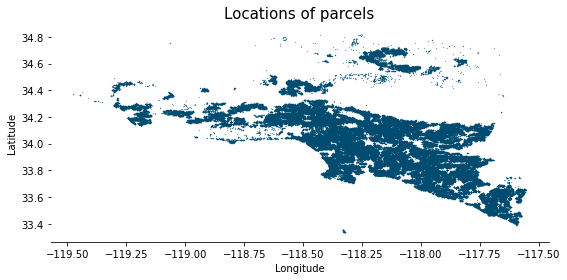

In [22]:
# overall region plot
plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
plt.plot(data['longitude'], data['latitude'], 'o', markersize = 0.2, color = '#004c70')
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.title('Locations of parcels', fontsize = 15)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

plt.tight_layout()

Additionaly, I plotted 3 counties with different colors. (Colors: Ventura - red, LA - grey, Orange - blue)<br>
Plus, `county` denotes specific regions, so it's better to convert those variable into categorical variable!

<br>

**Side notes**: `regionidcity` and `regionidneighborhood` has too many unique values, and there is no significant difference in logerror among values in those variables. 

In [23]:
# convert to categorical variable
new_cat = []
for value in data['regionidcounty'].values:
    if value == 1286:
        new_cat.append('Orange')
    elif value == 2061:
        new_cat.append('Ventura')
    else:
        new_cat.append('LA')

data['regionidcounty'] = new_cat

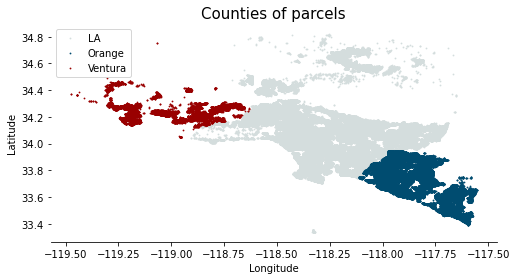

In [24]:
# county
colors = ['#d4dddd','#004c70', '#990000'] # originally 3, but includes NA values

plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
for i, c in enumerate(data['regionidcounty'].unique()):
    df = data[data['regionidcounty']==c]
    plt.plot(df['longitude'], df['latitude'], 'o', markersize = 0.8, color = colors[i], label = c)
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.title('Counties of parcels', fontsize = 15); plt.legend(loc = 'best')
    
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

### (4) Residence components analysis
In this section, I'll explore several important columns related to `logerror`. Here, important columns are columns whose correlation coefficient with logerror is relatively bigger than other columns.

#### Correlation Heatmap
Graph below shows correlation heatmap based on correlation coefficients with logerror. Overall coeffs are really small, maximum is 0.04. Therefore, I adjusted vmin and vmax to -0.05 and 0.05 each. According to this heatmap, important variables are **finishedsquarefeet12, calcuatedfinishedsquarefeet, calculatedbathnbr, bedroomcnt, fullbathcnt, bathroomcnt..etc**

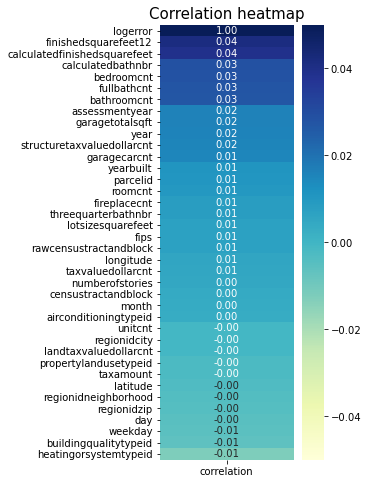

In [25]:
corr = pd.DataFrame(data.corr()['logerror'].sort_values(ascending = False)).rename(columns = {'logerror':'correlation'})

plt.figure(figsize = (3,8))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'YlGnBu')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

#### 1) Finished living area related variables
Two variables with top 2 correlation coefficients with logerror are `finishedsquarefeet12` and `calculatedfinishedsquarefeet`. Let's take a loot at descriptions first. Descriptions about those two variables are quite similar.
* `finishedsquarefeet12`: Finished living area
* `calculatedfinishedsquarefeet`:  Calculated total finished living area of the home 



Distribution of `finishedsquarefeet12` and `calculatedfinishedsquarefeet` are very similar, the only difference is that `calculatedfinishedsquarefeet` has some larger values.

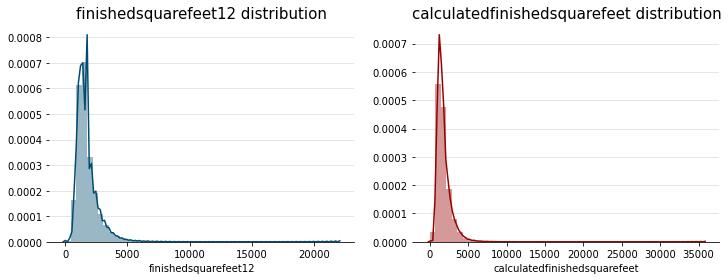

In [26]:
top2 = ['finishedsquarefeet12','calculatedfinishedsquarefeet']
colors = ['#004c70', '#990000']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
for i, col in enumerate(top2):
    sns.distplot(data[col], color = colors[i], ax = ax[i])
    ax[i].set_title(f'{col} distribution', fontsize = 15)

for s in ['top','left','right']:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)
ax[0].grid(axis='y', linestyle='-', alpha=0.4); ax[1].grid(axis='y', linestyle='-', alpha=0.4)

Correlation coefficient of those two variables is 0.958, which means that those variables are **highly correlated.** 

In [27]:
data[top2].corr()

,finishedsquarefeet12,calculatedfinishedsquarefeet
finishedsquarefeet12,1.000000,0.957626
calculatedfinishedsquarefeet,0.957626,1.000000


To analyze more specifically, let's take a look at jointplot of two variables. Except some values, those two variables are on function y = x.

<br>

To sum up, top 2 variables that have high correlation coefficients with logerror are highly correlated and they have similar values and both denote finished living area. For regression, it's always better to delete one of highly correlated variables since they might cause **multicolinearity** issues.

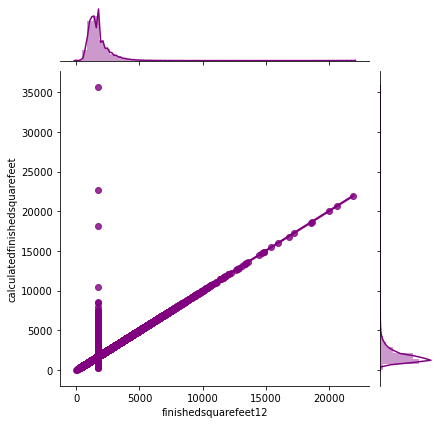

In [28]:
sns.jointplot(data = data, x = 'finishedsquarefeet12', y = 'calculatedfinishedsquarefeet', kind = 'reg', color = 'purple')

#### 2) Room types related variables
Room type variables, `bedroomcnt`, `bathroomcnt`, `fullbathcnt`, `calculatedbathnbr` have relatively high correlation coefficients with logerror. Among those vairables, three of them are related to bathroom. 
<br>

**Description**
* `bedroomcnt`:  Number of bedrooms in home 
* `bathroomcnt`:  Number of bathrooms in home including fractional bathrooms
* `fullbathcnt`:  Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
* `calculatedbathnbr`:  Number of bathrooms in home including fractional bathroom


`bedroomcnt` represents number of bedrooms in home. This ranges from 0 to 16. 
* Most of residences have 2-4 bedrooms in total
* As a number of room increases(if there are more than 8 rooms in home), mean logerror was larger than that of small numbe of bedrooms. This is because there are very few residences with more than 8 rooms, so it's hard to estimated house prices with small amount of data.

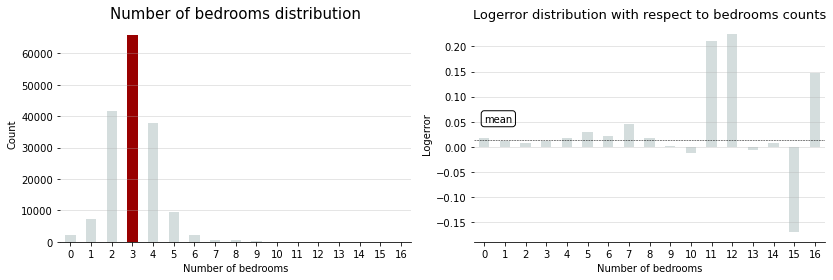

In [53]:
# change to integer type
data['bedroomcnt'] = data['bedroomcnt'].astype(int)


plt.figure(figsize = (12,4))
color_map = ['#d4dddd' for _ in range(len(data['bedroomcnt'].unique()))]
color_map2 = ['#d4dddd' for _ in range(len(data['bedroomcnt'].unique()))]
color_map[3] = '#990000'

ax1 = plt.subplot(1,2,1)
data.groupby('bedroomcnt')['logerror'].count().plot.bar(color = color_map)
plt.xticks(rotation = 0); plt.xlabel('Number of bedrooms'); plt.ylabel('Count')
plt.title('Number of bedrooms distribution', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)


ax2 = plt.subplot(1,2,2)
data.groupby('bedroomcnt')['logerror'].mean().plot.bar(color = color_map2)
plt.axhline(data['logerror'].mean(), linestyle = '--', color = 'black', linewidth = 0.5)
plt.text(0, 0.05, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.xticks(rotation = 0); plt.xlabel('Number of bedrooms'); plt.ylabel('Logerror')
plt.title('Logerror distribution with respect to bedrooms counts', fontsize = 13)


# axis setting
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

Let's analyze three bathroom count related variables. First, they are also highly correlated, correlation coefficients are over 0.9.

In [58]:
bathroom = ['bathroomcnt','fullbathcnt','calculatedbathnbr']
data[bathroom] = data[bathroom].astype(int)
data[bathroom].corr()

,bathroomcnt,fullbathcnt,calculatedbathnbr
bathroomcnt,1.000000,0.977820,0.978427
fullbathcnt,0.977820,1.000000,0.999385
calculatedbathnbr,0.978427,0.999385,1.000000


* Number of bathrooms and number of full bathrooms(sink, shower+tub, toilet) are different as we can expect.
* Distribution of `fullbathcnt` and `calculatedbathnbr` perfectly overlap. (Their correlation coef is 0.99) From this, we know that those two variables both denotes full bathroom + fraction bathroom counts. To avoid multicolinearity problem, I'll remove one of those variables in feature engineering part.

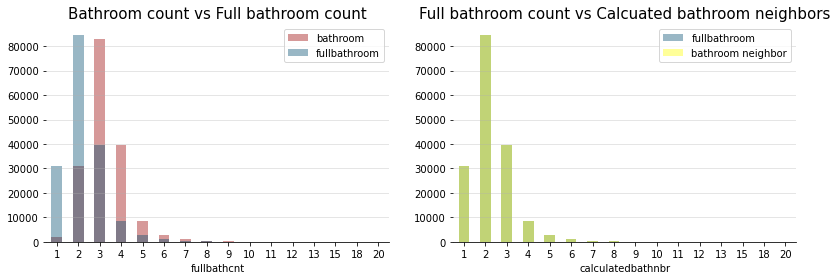

In [75]:
plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
data.groupby('bathroomcnt')['logerror'].count().plot.bar(color = '#990000', alpha = 0.4, label = 'bathroom')
data.groupby('fullbathcnt')['logerror'].count().plot.bar(color = '#004c70', alpha = 0.4, label = 'fullbathroom')
plt.title('Bathroom count vs Full bathroom count', fontsize =15); plt.xticks(rotation = False); plt.legend()

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

ax2 = plt.subplot(1,2,2)
data.groupby('fullbathcnt')['logerror'].count().plot.bar(color = '#004c70', alpha = 0.4, label = 'fullbathroom' )
data.groupby('calculatedbathnbr')['logerror'].count().plot.bar(color = 'yellow', alpha = 0.4, label = 'bathroom neighbor')
plt.title('Full bathroom count vs Calcuated bathroom neighbors', fontsize =15); plt.xticks(rotation = False); plt.legend()

for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)
plt.tight_layout()